In [1]:
#!conda install -c conda-forge econml shap --yes


In [1]:
import pandas as pd
import numpy as np
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap

### Load the data

In [3]:
df = pd.read_csv("/Users/tu/Library/CloudStorage/OneDrive-DickinsonCollege/Junior/SPRING25/ECON314/Project/Final data & Analysis/ML model/ml.csv")

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
df.head()

,year,serial,hhwt,pernum,perwt,nchild,eldch,sex,age,marst,...,uhrswork,inctot,occscore,occ_gr,has_child,female,parent,generation,age_firstkid,parent_age
0,2023,1,6,1,6,0 children present,NaN,female,86,widowed,...,NaN,11500,0,NaN,0,1,Women no kids,Silent,NaN,Not a parent
1,2023,4,11,1,11,0 children present,NaN,female,13,never married/single,...,NaN,9999999,0,NaN,0,1,Women no kids,Gen Z,NaN,Not a parent
2,2023,5,57,1,57,0 children present,NaN,male,18,never married/single,...,28,2500,29,Production,0,0,Men no kids,Gen Z,NaN,Not a parent
3,2023,6,52,1,52,0 children present,NaN,male,19,never married/single,...,30,500,13,Services,0,0,Men no kids,Gen Z,NaN,Not a parent
4,2023,8,1,1,1,0 children present,NaN,male,71,divorced,...,NaN,15600,0,NaN,0,0,Men no kids,Baby Boomers,NaN,Not a parent


In [5]:
df.columns

Index(['year', 'serial', 'hhwt', 'pernum', 'perwt', 'nchild', 'eldch', 'sex',
       'age', 'marst', 'race', 'raced', 'educ', 'educd', 'degfield', 'empstat',
       'classwkr', 'classwkrd', 'uhrswork', 'inctot', 'occscore', 'occ_gr',
       'has_child', 'female', 'parent', 'generation', 'age_firstkid',
       'parent_age'],
      dtype='object')

In [6]:
df.head()

,year,serial,hhwt,pernum,perwt,nchild,eldch,sex,age,marst,...,uhrswork,inctot,occscore,occ_gr,has_child,female,parent,generation,age_firstkid,parent_age
0,2023,1,6,1,6,0 children present,NaN,female,86,widowed,...,NaN,11500,0,NaN,0,1,Women no kids,Silent,NaN,Not a parent
1,2023,4,11,1,11,0 children present,NaN,female,13,never married/single,...,NaN,9999999,0,NaN,0,1,Women no kids,Gen Z,NaN,Not a parent
2,2023,5,57,1,57,0 children present,NaN,male,18,never married/single,...,28,2500,29,Production,0,0,Men no kids,Gen Z,NaN,Not a parent
3,2023,6,52,1,52,0 children present,NaN,male,19,never married/single,...,30,500,13,Services,0,0,Men no kids,Gen Z,NaN,Not a parent
4,2023,8,1,1,1,0 children present,NaN,male,71,divorced,...,NaN,15600,0,NaN,0,0,Men no kids,Baby Boomers,NaN,Not a parent


### Data Processing

In [8]:
# Clean the column to extract just the number
df['nchild'] = df['nchild'].astype(str).str.extract(r'(\d+)').astype(int)

In [9]:
# Define parenthood status
df["parent_bin"] = (df["nchild"] > 0).astype(int)

In [10]:
df = df.dropna(subset=["age", "educ", "marst", "uhrswork", "race", "female", "generation", "parent_age", "occ_gr", "inctot", "nchild", "perwt"])

In [11]:
df['age'] = df['age'].replace("90 (90+ in 1980 and 1990)", 90)
df['uhrswork'] = df['uhrswork'].replace("99 (topcode)", 99)

In [12]:
df['uhrswork'].unique()

array(['28', '30', '10', '55', '15', '40', '50', '12', '1', '23', '52',
       '7', '25', '35', '60', '20', '32', '17', '80', '5', '8', '18',
       '16', '24', '65', '3', '31', '22', '45', '14', '36', '38', '27',
       '82', '42', '6', '26', '41', '48', '84', '4', '37', '70', '44',
       '19', '75', '47', '53', '72', '68', '43', '90', '56', '39', 99,
       '64', '96', '33', '2', '11', '29', '63', '9', '46', '51', '62',
       '61', '54', '49', '88', '67', '79', '58', '13', '85', '34', '21',
       '66', '77', '89', '76', '57', '91', '87', '92', '94', '98', '78',
       '69', '83', '86', '95', '81', '74', '71', '59', '73', '97', '93'],
      dtype=object)

In [13]:
df['uhrswork'] =  df['uhrswork'].astype(float)

In [14]:
df['age']= df['age'].astype(float)

In [15]:
df.dtypes

year              int64
serial            int64
hhwt              int64
pernum            int64
perwt             int64
nchild            int64
eldch            object
sex              object
age             float64
marst            object
race             object
raced            object
educ             object
educd            object
degfield         object
empstat          object
classwkr         object
classwkrd        object
uhrswork        float64
inctot            int64
occscore          int64
occ_gr           object
has_child         int64
female            int64
parent           object
generation       object
age_firstkid    float64
parent_age       object
parent_bin        int64
dtype: object

In [16]:
df[df['parent_bin']==1]

,year,serial,hhwt,pernum,perwt,nchild,eldch,sex,age,marst,...,inctot,occscore,occ_gr,has_child,female,parent,generation,age_firstkid,parent_age,parent_bin
2409,2023,3712,126,1,126,1,20,female,40.0,"married, spouse present",...,6500,25,Transport and material moving,1,1,Mothers,Gen Y,20.0,Young parent,1
2410,2023,3712,126,2,146,1,20,male,41.0,"married, spouse present",...,65000,23,Production,1,0,Fathers,Gen Y,21.0,Young parent,1
2412,2023,3713,76,1,76,2,14,female,36.0,never married/single,...,39000,16,Services,1,1,Mothers,Gen Y,22.0,Young parent,1
2413,2023,3713,76,2,89,2,14,male,40.0,never married/single,...,18500,20,Transport and material moving,1,0,Fathers,Gen Y,26.0,Young parent,1
2416,2023,3714,21,1,22,3,24,female,40.0,divorced,...,13300,14,Services,1,1,Mothers,Gen Y,16.0,Young parent,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690675,2023,1519003,13,1,13,1,32,male,65.0,"married, spouse present",...,35360,30,"Computer, Engineering, and Science",1,0,Fathers,Baby Boomers,33.0,Middle-aged parent,1
2690677,2023,1519003,13,3,23,2,10,female,32.0,never married/single,...,54200,16,Services,1,1,Mothers,Gen Y,22.0,Young parent,1
2690679,2023,1519005,352,1,352,1,38,male,65.0,"married, spouse present",...,12800,20,Construction and Extraction,1,0,Fathers,Baby Boomers,27.0,Young parent,1
2690682,2023,1519006,45,1,45,1,26,male,58.0,"married, spouse present",...,62400,42,Sales,1,0,Fathers,Gen X,32.0,Middle-aged parent,1


In [17]:
df = df[df["inctot"] != 1] 
df = df[df["inctot"]>0]
df = df[df["inctot"]>10000]

In [18]:
df

,year,serial,hhwt,pernum,perwt,nchild,eldch,sex,age,marst,...,inctot,occscore,occ_gr,has_child,female,parent,generation,age_firstkid,parent_age,parent_bin
11,2023,18,77,1,77,0,NaN,female,45.0,"married, spouse absent",...,30000,23,Production,0,1,Women no kids,Gen X,NaN,Not a parent,0
15,2023,23,3,1,3,0,NaN,male,52.0,divorced,...,20000,30,Production,0,0,Men no kids,Gen X,NaN,Not a parent,0
16,2023,24,25,1,25,0,NaN,male,52.0,"married, spouse absent",...,31200,19,Services,0,0,Men no kids,Gen X,NaN,Not a parent,0
22,2023,38,41,1,41,0,NaN,male,44.0,"married, spouse absent",...,37000,42,Sales,0,0,Men no kids,Gen X,NaN,Not a parent,0
26,2023,46,20,1,20,0,NaN,male,36.0,"married, spouse absent",...,30000,17,Services,0,0,Men no kids,Gen Y,NaN,Not a parent,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690684,2023,1519006,45,3,63,0,NaN,male,26.0,never married/single,...,22000,19,Services,0,0,Men no kids,Gen Z,NaN,Not a parent,0
2690685,2023,1519007,125,1,125,0,NaN,female,70.0,widowed,...,30000,16,Services,0,1,Women no kids,Baby Boomers,NaN,Not a parent,0
2690687,2023,1519007,125,3,69,0,NaN,male,42.0,never married/single,...,13400,16,Services,0,0,Men no kids,Gen Y,NaN,Not a parent,0
2690689,2023,1519008,77,1,78,0,NaN,male,53.0,"married, spouse present",...,80000,27,"Education, Legal, Community Service, Arts, and...",0,0,Men no kids,Gen X,NaN,Not a parent,0


In [19]:
#df.to_csv("finally-finished-data.csv", index=False)

In [20]:
df.columns

Index(['year', 'serial', 'hhwt', 'pernum', 'perwt', 'nchild', 'eldch', 'sex',
       'age', 'marst', 'race', 'raced', 'educ', 'educd', 'degfield', 'empstat',
       'classwkr', 'classwkrd', 'uhrswork', 'inctot', 'occscore', 'occ_gr',
       'has_child', 'female', 'parent', 'generation', 'age_firstkid',
       'parent_age', 'parent_bin'],
      dtype='object')



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



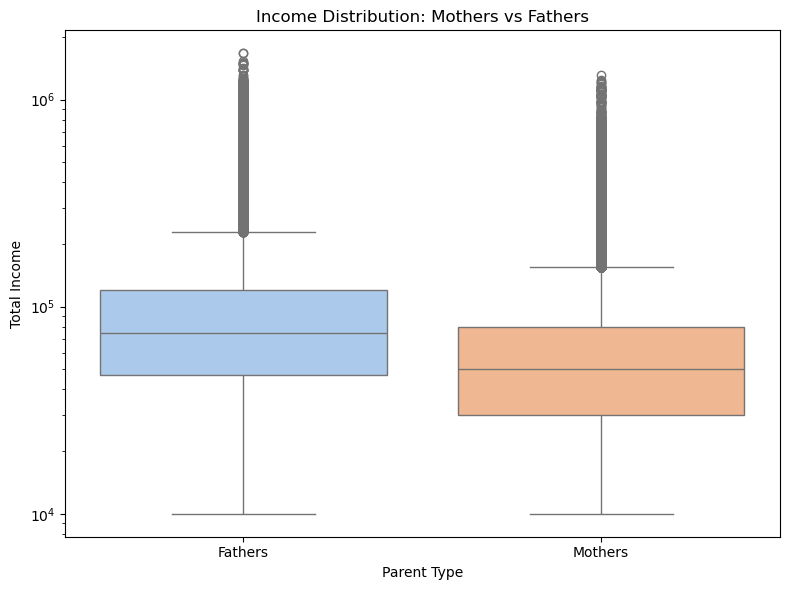

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

df_parent = df[df['parent'].isin(["Mothers", "Fathers"])]

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_parent, x='parent', y='inctot', palette='pastel')
plt.title('Income Distribution: Mothers vs Fathers')
plt.ylabel('Total Income')
plt.xlabel('Parent Type')
plt.yscale('log')  # Optional: log scale to handle income outliers
plt.tight_layout()
plt.show()

In [180]:
df_parent

11         0
15         0
16         0
22         0
26         0
          ..
2690684    0
2690685    0
2690687    0
2690689    0
2690691    0
Name: parent_bin, Length: 1540944, dtype: int64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



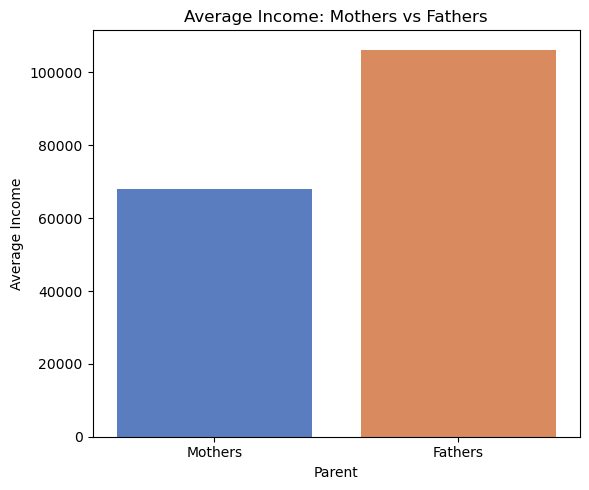

In [26]:
avg_income = df_parent.groupby('parent')['inctot'].mean().reset_index()

plt.figure(figsize=(6, 5))
sns.barplot(data=avg_income, x='parent', y='inctot', palette='muted', order = ["Mothers", "Fathers"])
plt.title('Average Income: Mothers vs Fathers')
plt.ylabel('Average Income')
plt.xlabel('Parent')
plt.tight_layout()
plt.show()

### Casual Forest DML 

In [30]:
# Define outcome, treatment, and controls
Y = np.log1p(df["inctot"]).values
D = df["parent_bin"].values
X = df[["age", "educ", "marst", "uhrswork", "race", "female", "generation", "parent_age", "occ_gr"]]


In [32]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=["educ", "marst", "race", "generation", "occ_gr", "parent_age"])

### Take a small sample

In [24]:
# sample_frac = 0.4  # 10% of data
# df_sample = df.sample(frac=sample_frac, random_state=40)

# Y = df_sample['inctot'].values
# D = df_sample['parent_bin'].values
# X = df_sample[["age", "educ", "marst", "uhrswork", "race", "female", "generation", "parent_age", "occ_gr"]]  # assuming X_encoded matches

In [186]:
# check for Null values
print(X_encoded.isnull().sum())

age                                                            0
uhrswork                                                       0
female                                                         0
educ_1 year of college                                         0
educ_2 years of college                                        0
educ_4 years of college                                        0
educ_5+ years of college                                       0
educ_grade 10                                                  0
educ_grade 11                                                  0
educ_grade 12                                                  0
educ_grade 5, 6, 7, or 8                                       0
educ_grade 9                                                   0
educ_n/a or no schooling                                       0
educ_nursery school to grade 4                                 0
marst_divorced                                                 0
marst_married, spouse abs

### Run Causal DML without propensity score matching

In [28]:
# Define sample weights
sample_weight = df["perwt"].values
sample_weight = sample_weight * (len(sample_weight) / np.sum(sample_weight))  # normalize to sample size
print(X_encoded.shape, Y.shape, D.shape, sample_weight.shape)

(1540944, 50) (1540944,) (1540944,) (1540944,)


In [29]:
# --- Causal Forest DML ---
model_y = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
model_t = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)

est = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=True,
    n_estimators=100,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42,
)

est.fit(Y, D, X=X_encoded, sample_weight=sample_weight)



### Run Causal DML with Propensity Score Matching

In [60]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

# Estimate propensity scores
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_encoded, D)
propensity_scores = ps_model.predict_proba(X_encoded)[:, 1]

# Add propensity scores to the original DataFrame
df["ps"] = propensity_scores

# Compute weights using the inverse of propensity scores
df['weights'] = np.where(df['parent_bin'] == 1, 1 / df['ps'], 1 / (1 - df['ps']))

# Now, you can use these weights in your model
df_trimmed = df.copy()  # No trimming, we keep all data

Y_trimmed = np.log1p(df_trimmed["inctot"]).values
D_trimmed = df_trimmed["parent_bin"].values

# One-hot encode categorical variables using pd.get_dummies
X_trimmed = pd.get_dummies(df_trimmed[["age", "educ", "marst", "uhrswork", "race", "female", "generation", "parent_age", "occ_gr"]],
                            columns=["educ", "marst", "race", "generation", "occ_gr", "parent_age"])

weights_trimmed = df_trimmed["weights"].values
weights_trimmed = weights_trimmed * (len(weights_trimmed) / np.sum(weights_trimmed))  # Normalize to sample size

# Now you have Y_trimmed, D_trimmed, X_trimmed, and weights_trimmed ready for further analysis




In [110]:
X_trimmed

,age,uhrswork,female,educ_1 year of college,educ_2 years of college,educ_4 years of college,educ_5+ years of college,educ_grade 10,educ_grade 11,educ_grade 12,...,"occ_gr_Management, Business, and Finance",occ_gr_Office and Admin Support,occ_gr_Production,occ_gr_Sales,occ_gr_Services,occ_gr_Transport and material moving,parent_age_Middle-aged parent,parent_age_Not a parent,parent_age_Old parent,parent_age_Young parent
11,45.0,55.0,1,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
15,52.0,40.0,0,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
16,52.0,50.0,0,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
22,44.0,52.0,0,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
26,36.0,40.0,0,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2690684,26.0,40.0,0,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False
2690685,70.0,64.0,1,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False
2690687,42.0,35.0,0,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
2690689,53.0,45.0,0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [64]:
# --- Causal Forest DML ---
model_y_p = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
model_t_p = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)

est = CausalForestDML(
    model_y=model_y_p,
    model_t=model_t_p,
    discrete_treatment=True,
    n_estimators=100,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42,
)

est.fit(Y_trimmed, D_trimmed, X=X_trimmed, sample_weight=weights_trimmed)

In [102]:
print(X_trimmed.shape, Y_trimmed.shape, D_trimmed.shape, weights_trimmed.shape)

(1540944, 50) (1540944,) (1540944,) (1540944,)


In [286]:
D_trimmed

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# Estimate the ATE (Average Treatment Effect)
ate_trimmed = est.ate(X_trimmed)
print(f"Estimated ATE: {ate_trimmed}")

# Get ATE and confidence interval
ate_trimmed = est.ate(X_trimmed)
ate_lb_trimmed, ate_ub_trimmed = est.ate_interval(X_trimmed)

# Compute standard error from 95% confidence interval (z = 1.96)
ate_se_trimmed = (ate_ub_trimmed - ate_lb_trimmed) / (2 * 1.96)

# Now compute t-statistic
t_stat_trimmed = ate_trimmed / ate_se_trimmed


Estimated ATE: -0.04155485754838876


In [71]:
print(ate_lb_trimmed, ate_ub_trimmed)

-0.09539866819811443 0.012288953101336916


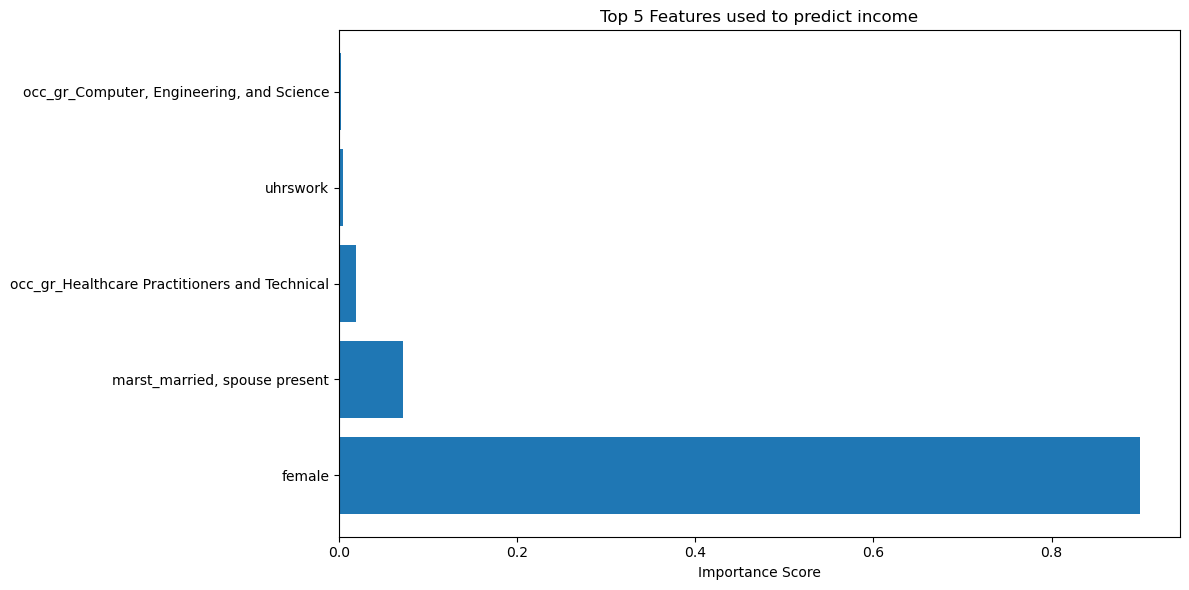

In [74]:
importances = est.feature_importances_
features = X_trimmed.columns

# Sort the feature importances and get the top 5
sorted_idx = importances.argsort()[::-1]  # Sort in descending order
top_5_idx = sorted_idx[:5]  # Get the indices of the top 5 features

# Plot the top 10 features
plt.figure(figsize=(12, 6))
plt.barh(features[top_5_idx], importances[top_5_idx])
plt.xlabel("Importance Score")
plt.title("Top 5 Features used to predict income")
plt.tight_layout()
plt.show()


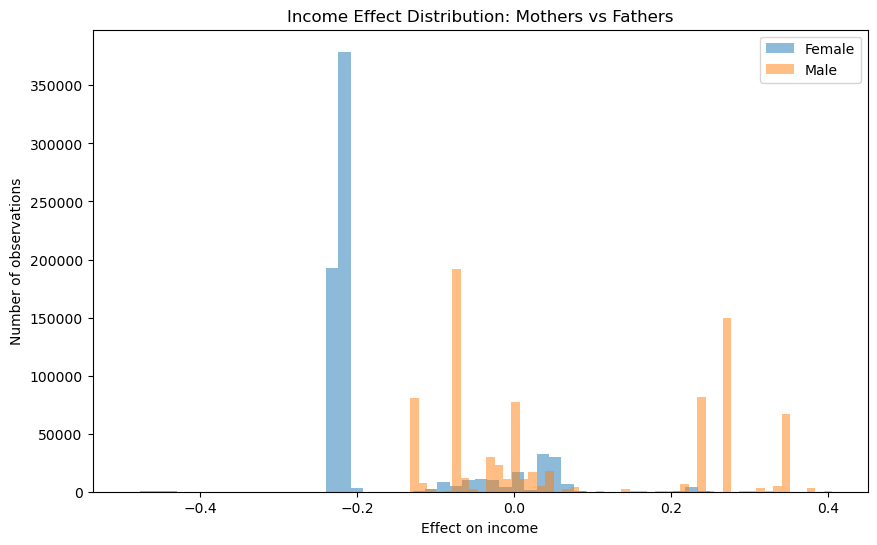

In [76]:
import matplotlib.pyplot as plt

# Plot the treatment effects for female and male individuals
plt.figure(figsize=(10, 6))

plt.hist(est.effect(X_trimmed[X_trimmed['female']==1]), alpha=0.5, label='Female', bins=50)
plt.hist(est.effect(X_trimmed[X_trimmed['female']==0]), alpha=0.5, label='Male', bins=50)

plt.title('Income Effect Distribution: Mothers vs Fathers')
plt.xlabel('Effect on income')
plt.ylabel('Number of observations')
plt.legend()
plt.show()

In [78]:
# --- Example: Estimating Treatment Effect Between Male and Female ---

# Create mask for female individuals (SEX == 2)
female_gr = (df["female"] == 1)

# Create mask for male individuals (SEX == 1)
male_gr = (df["female"] == 0)

# Estimate the treatment effect for female individuals
cate_female = est.effect(X_trimmed[female_gr])

# Estimate the treatment effect for male individuals
cate_male = est.effect(X_trimmed[male_gr])



# Calculate the average treatment effect for both groups
avg_cate_female = cate_female.mean()
avg_cate_male = cate_male.mean()

# Log income means treatment effects are % changes!
# You can interpret this directly:
print(f"Female log-scale penalty: {cate_female.mean():.3f} ≈ {cate_female.mean() * 100:.1f}%")
print(f"Male log-scale penalty: {cate_male.mean():.3f} ≈ {cate_male.mean() * 100:.1f}%")


Female log-scale penalty: -0.176 ≈ -17.6%
Male log-scale penalty: 0.077 ≈ 7.7%


In [81]:
ate_lb_mom, ate_ub_mom = est.ate_interval(X_trimmed[X_trimmed['female']==1])
print(ate_lb_mom, ate_ub_mom)
ate_lb_dad, ate_ub_dad = est.ate_interval(X_trimmed[X_trimmed['female']==0])
print(ate_lb_dad, ate_ub_dad)

-0.22092705709189922 -0.1310182275598122
0.016372104846926493 0.13759347462792415


### Run pacebo to check if the model pick up wrong effect

In [84]:
import numpy as np

# Create a placebo treatment by shuffling the actual treatment
D_placebo = np.random.permutation(D_trimmed)

# Fit the model again using the placebo treatment
est_placebo = CausalForestDML(
    model_y=model_y_p,
    model_t=model_t_p,
    discrete_treatment=True,
    n_estimators=100,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42,
)

est_placebo.fit(Y_trimmed, D_placebo, X=X_trimmed, sample_weight=weights_trimmed)

# Estimate the placebo treatment effects
te_placebo = est_placebo.effect(X_trimmed)

# Summarize the results
print("Mean estimated effect (placebo):", np.mean(te_placebo))
print("Standard deviation:", np.std(te_placebo))

Mean estimated effect (placebo): -0.0005743413981659954
Standard deviation: 0.006046833757415293


### Test statisitcs

In [88]:
# For real model
from scipy.stats import ttest_ind

te_real = est.effect(X_trimmed)

t_stat, p_val = ttest_ind(te_real, te_placebo, equal_var=False)  # Welch’s t-test
print("T-statistic:", t_stat)
print("P-value:", p_val)


T-statistic: -269.6118541807627
P-value: 0.0


In [90]:
print("Mean real effect:", te_real.mean())
print("Mean placebo effect:", te_placebo.mean())

Mean real effect: -0.04155485754838875
Mean placebo effect: -0.0005743413981659954


### Compare the gender-based difference 

                 Group       N       ATE  CI Lower  CI Upper
0        Young mothers   88480 -0.191145 -0.220259 -0.162030
1  Middle-aged mothers  210097 -0.163984 -0.198411 -0.129556
2          Old mothers   11383 -0.159861 -0.193768 -0.125954
3        Young fathers  144503  0.005295 -0.035567  0.046158
4  Middle-aged fathers  169401 -0.016154 -0.061231  0.028923
5          Old fathers    9163 -0.002654 -0.048051  0.042744


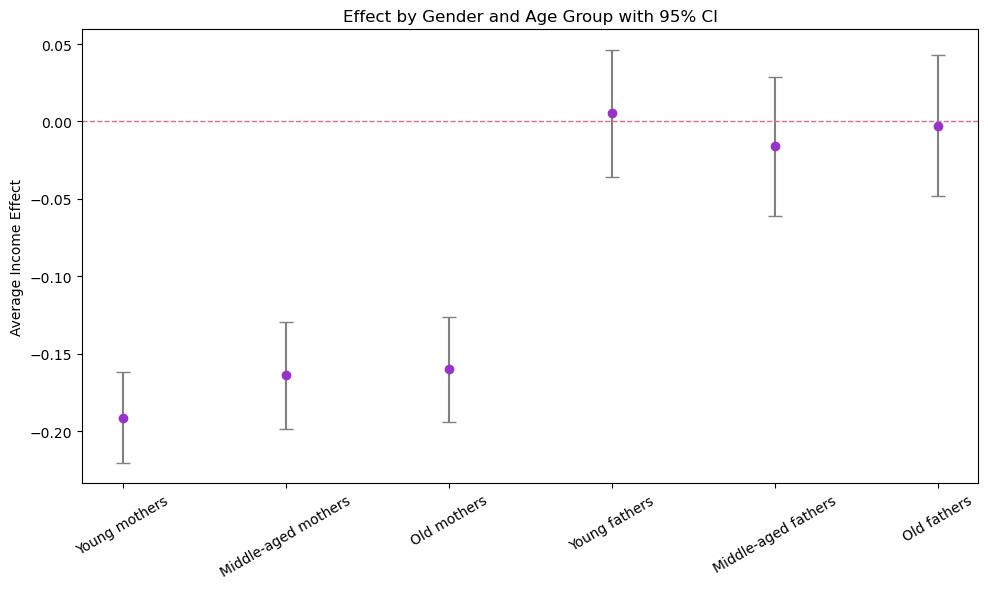

In [98]:
results = []

# Define your binary group logic
groups = [
    ('Young mothers',     (X_trimmed['female'] == 1) & (X_trimmed["parent_age_Young parent"] == 1)),
    ('Middle-aged mothers',    (X_trimmed['female'] == 1) & (X_trimmed["parent_age_Middle-aged parent"] == 1)),
    ('Old mothers',       (X_trimmed['female'] == 1) & (X_trimmed["parent_age_Old parent"] == 1)),
    ('Young fathers',       (X_trimmed['female'] == 0) & (X_trimmed["parent_age_Young parent"] == 1)),
    ('Middle-aged fathers',      (X_trimmed['female'] == 0) & (X_trimmed["parent_age_Middle-aged parent"] == 1)),
    ('Old fathers',         (X_trimmed['female'] == 0) & (X_trimmed["parent_age_Old parent"] == 1))]

for label, condition in groups:
    group_data = X_encoded[condition]
    if len(group_data) < 10:
        continue
    
    # Treatment effect and CI
    te = est.effect(group_data)
    lb, ub = est.effect_interval(group_data)
    
    results.append({
        'Group': label,
        'N': len(group_data),
        'ATE': te.mean(),
        'CI Lower': lb.mean(),
        'CI Upper': ub.mean()
    })

# Create the DataFrame
ate_df = pd.DataFrame(results)

# Print the results table
print(ate_df)

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(ate_df['Group'], ate_df['ATE'],
             yerr=[ate_df['ATE'] - ate_df['CI Lower'], ate_df['CI Upper'] - ate_df['ATE']],
             fmt='o', capsize=5, color='darkorchid', ecolor='gray')

plt.axhline(0, linestyle='--', color='palevioletred', linewidth=1)
plt.title('Effect by Gender and Age Group with 95% CI')
plt.ylabel('Average Income Effect')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### Compare the age-based difference

           Group       N       ATE  CI Lower  CI Upper
0  Gen X mothers  238178 -0.168673 -0.200008 -0.137338
1  Gen Y mothers  239801 -0.170127 -0.205482 -0.134771
2  Gen Z mothers   85050 -0.196631 -0.227371 -0.165891
3  Gen X fathers  260517  0.045735 -0.000527  0.091997
4  Gen Y fathers  274589  0.084367  0.033318  0.135415
5  Gen Z fathers   99859  0.220933  0.163499  0.278366


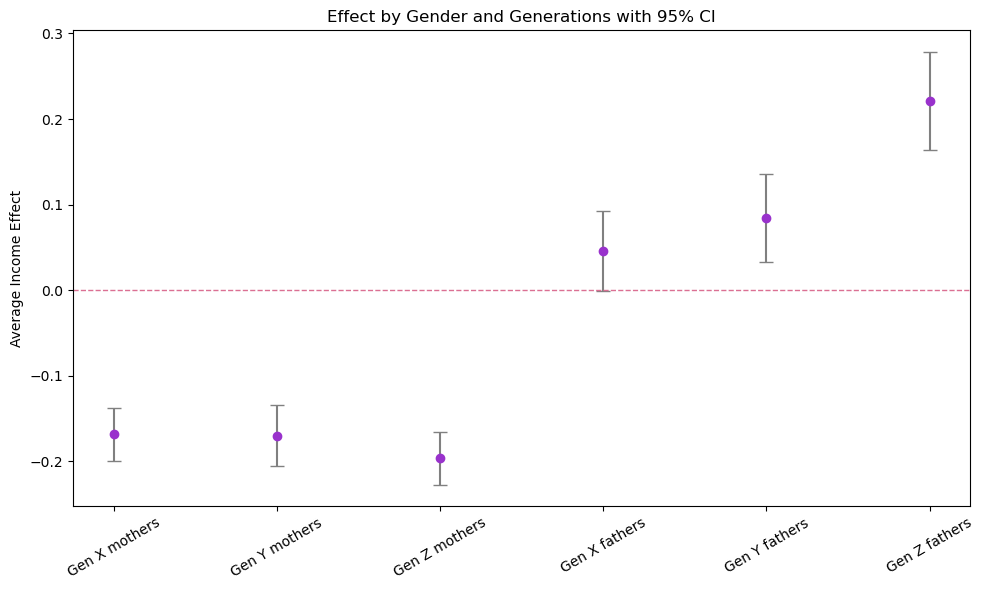

In [100]:
results2 = []

# Define your binary group logic
groups = [
    ('Gen X mothers',     (X_trimmed['female'] == 1) & (X_trimmed["generation_Gen X"] == 1)),
    ('Gen Y mothers',    (X_trimmed['female'] == 1) & (X_trimmed["generation_Gen Y"] == 1)),
    ('Gen Z mothers',       (X_trimmed['female'] == 1) & (X_trimmed["generation_Gen Z"] == 1)),
    ('Gen X fathers',       (X_trimmed['female'] == 0) & (X_trimmed["generation_Gen X"] == 1)),
    ('Gen Y fathers',      (X_trimmed['female'] == 0) & (X_trimmed["generation_Gen Y"] == 1)),
    ('Gen Z fathers',         (X_trimmed['female'] == 0) & (X_trimmed["generation_Gen Z"] == 1))]

for label, condition in groups:
    group_data = X_encoded[condition]
    if len(group_data) < 10:
        continue
    
    # Treatment effect and CI
    te = est.effect(group_data)
    lb, ub = est.effect_interval(group_data)
    
    results2.append({
        'Group': label,
        'N': len(group_data),
        'ATE': te.mean(),
        'CI Lower': lb.mean(),
        'CI Upper': ub.mean()
    })

# Create the DataFrame
ate_df = pd.DataFrame(results2)

# Print the results table
print(ate_df)

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(ate_df['Group'], ate_df['ATE'],
             yerr=[ate_df['ATE'] - ate_df['CI Lower'], ate_df['CI Upper'] - ate_df['ATE']],
             fmt='o', capsize=5, color='darkorchid', ecolor='gray')

plt.axhline(0, linestyle='--', color='palevioletred', linewidth=1)
plt.title('Effect by Gender and Generations with 95% CI')
plt.ylabel('Average Income Effect')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### Check model performance (confidence interval)

In [30]:
# Estimate the ATE (Average Treatment Effect)
ate = est.ate(X_encoded)
print(f"Estimated ATE: {ate}")

Estimated ATE: -0.044134986004924694


In [79]:
# Get ATE and confidence interval
ate = est.ate(X_encoded)
ate_lb, ate_ub = est.ate_interval(X_encoded)

# Compute standard error from 95% confidence interval (z = 1.96)
ate_se = (ate_ub - ate_lb) / (2 * 1.96)

# Now compute t-statistic
t_stat = ate / ate_se

In [142]:
print(ate_lb, ate_ub)

-0.11642552576489533 0.028155553755045915


In [85]:
from scipy import stats

p_value = 2 * stats.norm.sf(abs(-1.1966))
print(p_value)

0.23146250048160588


In [31]:
# Variance of the treatment effect estimate (useful for model confidence)
print("Variance of treatment effect predictions:", np.var(est.effect(X_encoded)))

# Score method provides a R-learner style test MSE (lower is better)
print("Model score (R-learning MSE):", est.score(Y, D, X=X_encoded))

Variance of treatment effect predictions: 0.02790300975733056
Model score (R-learning MSE): 0.3907651244603953


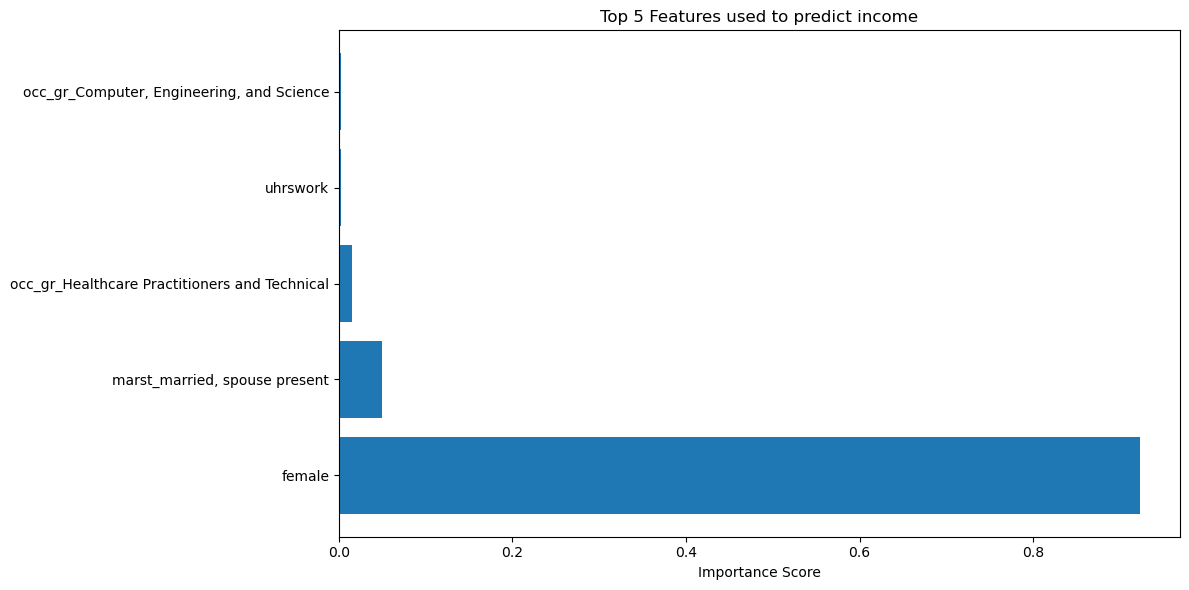

In [91]:
importances = est.feature_importances_
features = X_encoded.columns

# Sort the feature importances and get the top 5
sorted_idx = importances.argsort()[::-1]  # Sort in descending order
top_5_idx = sorted_idx[:5]  # Get the indices of the top 5 features

# Plot the top 10 features
plt.figure(figsize=(12, 6))
plt.barh(features[top_5_idx], importances[top_5_idx])
plt.xlabel("Importance Score")
plt.title("Top 5 Features used to predict income")
plt.tight_layout()
plt.show()


In [70]:

# Create a table of top 10 features and their importances
top_features_table = pd.DataFrame({
    'Feature': features[top_10_idx],
    'Importance': importances[top_10_idx]
})

# Optional: sort by importance for a cleaner table
top_features_table = top_features_table.sort_values(by='Importance', ascending=False)

print(top_features_table)

                                             Feature  Importance
0                                             female    0.923180
1                      marst_married, spouse present    0.049824
2      occ_gr_Healthcare Practitioners and Technical    0.015248
3                                           uhrswork    0.002553
4          occ_gr_Computer, Engineering, and Science    0.002065
5                                         race_white    0.001828
6                                                age    0.001724
7                           educ_5+ years of college    0.001313
8  occ_gr_Education, Legal, Community Service, Ar...    0.001131
9                                    occ_gr_Services    0.000202


In [33]:
# --- Example: Estimating Treatment Effect Between Male and Female ---

# Create mask for female individuals (SEX == 2)
mask_female = (df["female"] == 1)

# Create mask for male individuals (SEX == 1)
mask_male = (df["female"] == 0)

# Estimate the treatment effect for female individuals
cate_female = est.effect(X_encoded[mask_female])

# Estimate the treatment effect for male individuals
cate_male = est.effect(X_encoded[mask_male])



# Calculate the average treatment effect for both groups
avg_cate_female = cate_female.mean()
avg_cate_male = cate_male.mean()

# Log income means treatment effects are % changes!
# You can interpret this directly:
print(f"Female log-scale penalty: {cate_female.mean():.3f} ≈ {cate_female.mean() * 100:.1f}%")
print(f"Male log-scale penalty: {cate_male.mean():.3f} ≈ {cate_male.mean() * 100:.1f}%")



Female log-scale penalty: -0.182 ≈ -18.2%
Male log-scale penalty: 0.077 ≈ 7.7%


In [146]:
ate_lb_mom, ate_ub_mom = est.ate_interval(X_encoded[X_encoded['female']==1])
print(ate_lb_mom, ate_ub_mom)

-0.24983044876702348 -0.11406383687722292


In [148]:
ate_lb_dad, ate_ub_dad = est.ate_interval(X_encoded[X_encoded['female']==0])
print(ate_lb_dad, ate_ub_dad)

0.0014307891382257937 0.15336125424726876


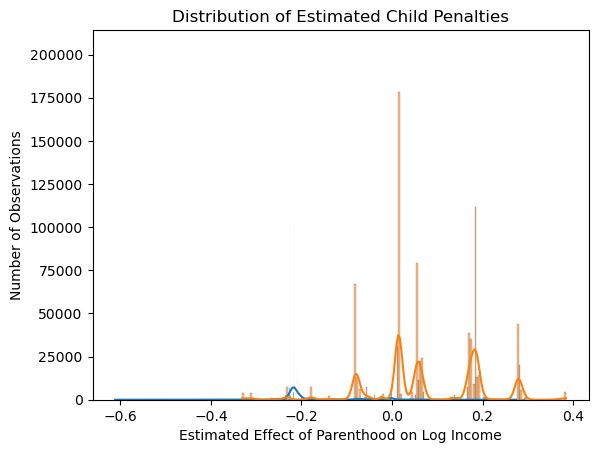

In [131]:
# Distribution of effects
import seaborn as sns
sns.histplot(est.effect(X_encoded), kde=True)
plt.title("Distribution of Estimated Child Penalties")
plt.xlabel("Estimated Effect of Parenthood on Log Income")
plt.ylabel("Number of Observations")
plt.show()


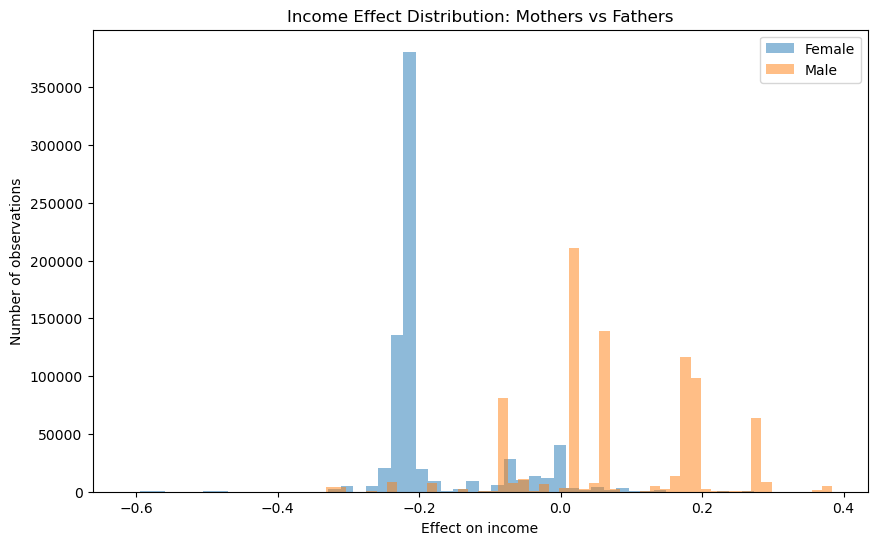

In [137]:
import matplotlib.pyplot as plt

# Plot the treatment effects for female and male individuals
plt.figure(figsize=(10, 6))

plt.hist(est.effect(X_encoded[X_encoded['female']==1]), alpha=0.5, label='Female', bins=50)
plt.hist(est.effect(X_encoded[X_encoded['female']==0]), alpha=0.5, label='Male', bins=50)

plt.title('Income Effect Distribution: Mothers vs Fathers')
plt.xlabel('Effect on income')
plt.ylabel('Number of observations')
plt.legend()
plt.show()

In [36]:
young_mask = X_encoded["parent_age_Young parent"] == 1
mid_mask = X_encoded["parent_age_Middle-aged parent"] == 1
old_mask = X_encoded["parent_age_Old parent"] == 1

# Estimate CATEs for each subgroup
cate_young = est.effect(X_encoded[young_mask])
cate_mid = est.effect(X_encoded[mid_mask])
cate_old = est.effect(X_encoded[old_mask])

# Log income means treatment effects are % changes!
# You can interpret this directly:
print(f"Young log-scale penalty: {cate_young.mean():.3f} ≈ {cate_young.mean() * 100:.1f}%")
print(f"Middle-aged log-scale penalty: {cate_mid.mean():.3f} ≈ {cate_mid.mean() * 100:.1f}%")
print(f"Old log-scale penalty: {cate_old.mean():.3f} ≈ {cate_old.mean() * 100:.1f}%")


Young log-scale penalty: -0.054 ≈ -5.4%
Middle-aged log-scale penalty: -0.088 ≈ -8.8%
Old log-scale penalty: -0.085 ≈ -8.5%


                 Group       N       ATE  CI Lower  CI Upper
0        Young mothers   88480 -0.205421 -0.264145 -0.146696
1  Middle-aged mothers  210097 -0.171434 -0.218225 -0.124644
2          Old mothers   11383 -0.170319 -0.215678 -0.124960
3        Young fathers  144503  0.037990 -0.020810  0.096790
4  Middle-aged fathers  169401  0.016055 -0.044392  0.076501
5          Old fathers    9163  0.020701 -0.039412  0.080815


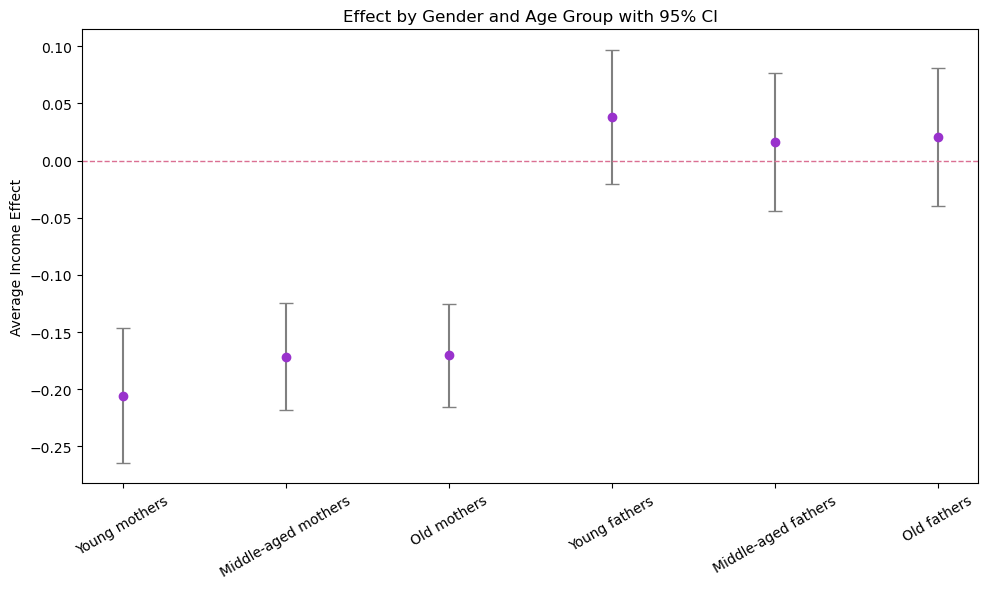

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

results = []

# Define your binary group logic
groups = [
    ('Young mothers',     (X_encoded['female'] == 1) & (X_encoded["parent_age_Young parent"] == 1)),
    ('Middle-aged mothers',    (X_encoded['female'] == 1) & (X_encoded["parent_age_Middle-aged parent"] == 1)),
    ('Old mothers',       (X_encoded['female'] == 1) & (X_encoded["parent_age_Old parent"] == 1)),
    ('Young fathers',       (X_encoded['female'] == 0) & (X_encoded["parent_age_Young parent"] == 1)),
    ('Middle-aged fathers',      (X_encoded['female'] == 0) & (X_encoded["parent_age_Middle-aged parent"] == 1)),
    ('Old fathers',         (X_encoded['female'] == 0) & (X_encoded["parent_age_Old parent"] == 1))]

for label, condition in groups:
    group_data = X_encoded[condition]
    if len(group_data) < 10:
        continue
    
    # Treatment effect and CI
    te = est.effect(group_data)
    lb, ub = est.effect_interval(group_data)
    
    results.append({
        'Group': label,
        'N': len(group_data),
        'ATE': te.mean(),
        'CI Lower': lb.mean(),
        'CI Upper': ub.mean()
    })

# Create the DataFrame
ate_df = pd.DataFrame(results)

# Print the results table
print(ate_df)

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(ate_df['Group'], ate_df['ATE'],
             yerr=[ate_df['ATE'] - ate_df['CI Lower'], ate_df['CI Upper'] - ate_df['ATE']],
             fmt='o', capsize=5, color='darkorchid', ecolor='gray')

plt.axhline(0, linestyle='--', color='palevioletred', linewidth=1)
plt.title('Effect by Gender and Age Group with 95% CI')
plt.ylabel('Average Income Effect')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

           Group       N       ATE  CI Lower  CI Upper
0  Gen X mothers  238178 -0.175917 -0.222072 -0.129763
1  Gen Y mothers  239801 -0.177301 -0.229368 -0.125233
2  Gen Z mothers   85050 -0.199855 -0.247619 -0.152091
3  Gen X fathers  260517  0.058869 -0.004154  0.121891
4  Gen Y fathers  274589  0.083269  0.014344  0.152193
5  Gen Z fathers   99859  0.163151  0.085309  0.240993


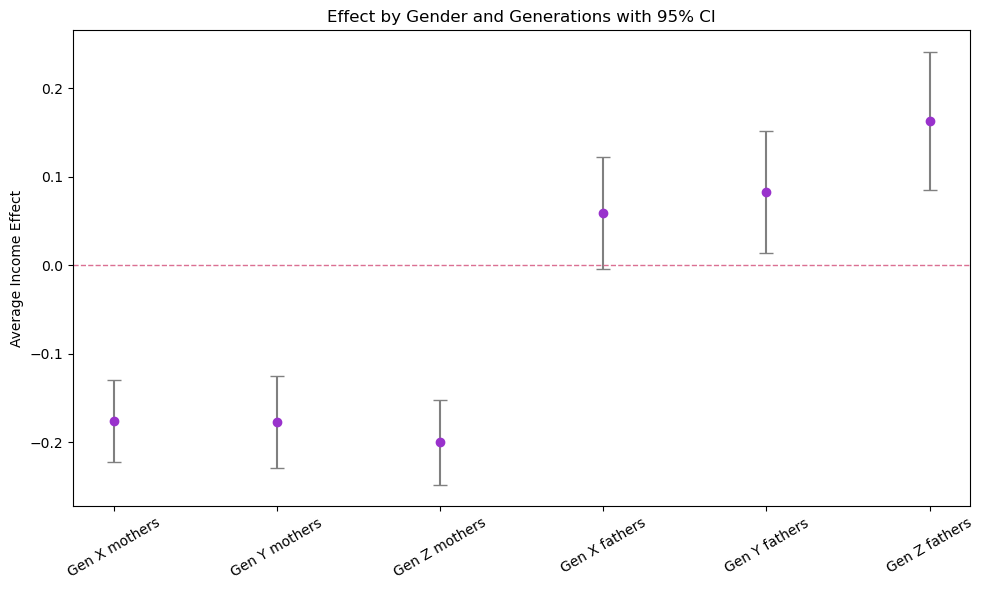

In [121]:
results2 = []

# Define your binary group logic
groups = [
    ('Gen X mothers',     (X_encoded['female'] == 1) & (X_encoded["generation_Gen X"] == 1)),
    ('Gen Y mothers',    (X_encoded['female'] == 1) & (X_encoded["generation_Gen Y"] == 1)),
    ('Gen Z mothers',       (X_encoded['female'] == 1) & (X_encoded["generation_Gen Z"] == 1)),
    ('Gen X fathers',       (X_encoded['female'] == 0) & (X_encoded["generation_Gen X"] == 1)),
    ('Gen Y fathers',      (X_encoded['female'] == 0) & (X_encoded["generation_Gen Y"] == 1)),
    ('Gen Z fathers',         (X_encoded['female'] == 0) & (X_encoded["generation_Gen Z"] == 1))]

for label, condition in groups:
    group_data = X_encoded[condition]
    if len(group_data) < 10:
        continue
    
    # Treatment effect and CI
    te = est.effect(group_data)
    lb, ub = est.effect_interval(group_data)
    
    results2.append({
        'Group': label,
        'N': len(group_data),
        'ATE': te.mean(),
        'CI Lower': lb.mean(),
        'CI Upper': ub.mean()
    })

# Create the DataFrame
ate_df = pd.DataFrame(results2)

# Print the results table
print(ate_df)

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(ate_df['Group'], ate_df['ATE'],
             yerr=[ate_df['ATE'] - ate_df['CI Lower'], ate_df['CI Upper'] - ate_df['ATE']],
             fmt='o', capsize=5, color='darkorchid', ecolor='gray')

plt.axhline(0, linestyle='--', color='palevioletred', linewidth=1)
plt.title('Effect by Gender and Generations with 95% CI')
plt.ylabel('Average Income Effect')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

### OLS

In [149]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Separate numerical and categorical
numerical = df[["age", "uhrswork"]]
categorical = pd.get_dummies(df[["educ", "race", "marst", "parent"]], drop_first=True)

# Combine and ensure all columns are numeric
X_encoded = pd.concat([numerical, categorical], axis=1).apply(pd.to_numeric, errors='coerce')

# Add constant term
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})
X_encoded = sm.add_constant(X_encoded)


# Prepare Y
Y = np.log1p(df["inctot"])

# Drop any rows with missing values
X_encoded, Y = X_encoded.align(Y, join='inner', axis=0)
data_clean = pd.concat([X_encoded, Y], axis=1).dropna()

# Final clean versions
X_final = data_clean.drop(columns=["inctot"])
Y_final = data_clean["inctot"]

# Fit the model
model = sm.OLS(Y_final, X_final).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                 inctot   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                 3.262e+04
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:47:48   Log-Likelihood:            -1.4588e+06
No. Observations:             1540944   AIC:                         2.918e+06
Df Residuals:                 1540915   BIC:                         2.918e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [140]:
X_final.dtypes

const                                   float64
age                                     float64
uhrswork                                float64
female                                    int64
educ_2 years of college                   int64
educ_4 years of college                   int64
educ_5+ years of college                  int64
educ_grade 10                             int64
educ_grade 11                             int64
educ_grade 12                             int64
educ_grade 5, 6, 7, or 8                  int64
educ_grade 9                              int64
educ_n/a or no schooling                  int64
educ_nursery school to grade 4            int64
race_black/african american               int64
race_chinese                              int64
race_japanese                             int64
race_other asian or pacific islander      int64
race_other race, nec                      int64
race_three or more major races            int64
race_two major races                    

In [147]:
X_final.corr().style.background_gradient(cmap="coolwarm")

All-NaN slice encountered
All-NaN slice encountered


,const,age,uhrswork,female,educ_2 years of college,educ_4 years of college,educ_5+ years of college,educ_grade 10,educ_grade 11,educ_grade 12,"educ_grade 5, 6, 7, or 8",educ_grade 9,educ_n/a or no schooling,educ_nursery school to grade 4,race_black/african american,race_chinese,race_japanese,race_other asian or pacific islander,"race_other race, nec",race_three or more major races,race_two major races,race_white,"marst_married, spouse absent","marst_married, spouse present",marst_never married/single,marst_separated,marst_widowed,parent_Men no kids,parent_Mothers,parent_Women no kids
const,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
age,nan,1.000000,-0.102301,0.001336,0.013598,-0.046397,0.072405,-0.006024,-0.030463,-0.007601,0.016758,0.001233,0.020664,0.016353,-0.002997,-0.013733,0.017245,-0.027265,-0.071779,-0.028995,-0.067640,0.105266,-0.008070,0.275716,-0.495896,0.019332,0.189441,-0.013600,-0.024817,0.023981
uhrswork,nan,-0.102301,1.000000,-0.162618,-0.007503,0.022038,0.033795,-0.012258,-0.024826,-0.019493,-0.000308,-0.003149,-0.002408,-0.002906,-0.010849,-0.001612,-0.002259,0.000699,-0.004101,0.000601,0.003222,0.006400,0.005818,0.060788,-0.037570,0.000150,-0.073035,0.031427,-0.056165,-0.132467
female,nan,0.001336,-0.162618,1.000000,0.037609,0.038224,0.056246,-0.020825,-0.018992,-0.077492,-0.031387,-0.019574,-0.019894,-0.009229,0.034159,0.010399,0.003610,0.005656,-0.016875,0.003513,-0.005076,-0.014237,-0.011405,-0.052782,-0.022523,0.022822,0.078342,-0.646768,0.534351,0.643451
educ_2 years of college,nan,0.013598,-0.007503,0.037609,1.000000,-0.186761,-0.145772,-0.027520,-0.032451,-0.216832,-0.034470,-0.025416,-0.036660,-0.015896,0.002477,-0.022391,0.000690,-0.023182,-0.018537,0.000681,-0.007657,0.029620,-0.007476,0.009879,-0.024765,0.000523,0.003959,-0.030021,0.029555,0.015634
educ_4 years of college,nan,-0.046397,0.022038,0.038224,-0.186761,1.000000,-0.262077,-0.049477,-0.058342,-0.389831,-0.061972,-0.045694,-0.065909,-0.028578,-0.044499,0.018582,0.018589,0.047348,-0.066889,-0.001619,-0.028313,0.054943,-0.017124,0.044095,0.000305,-0.026292,-0.030358,-0.029183,0.009800,0.034218
educ_5+ years of college,nan,0.072405,0.033795,0.056246,-0.145772,-0.262077,1.000000,-0.038618,-0.045537,-0.304273,-0.048371,-0.035665,-0.051443,-0.022306,-0.027471,0.077292,0.009593,0.068369,-0.070098,-0.004088,-0.036615,0.027372,-0.008338,0.120420,-0.099816,-0.022531,-0.018117,-0.066425,0.051156,0.017083
educ_grade 10,nan,-0.006024,-0.012258,-0.020825,-0.027520,-0.049477,-0.038618,1.000000,-0.008597,-0.057443,-0.009132,-0.006733,-0.009712,-0.004211,0.007550,-0.006266,-0.004151,-0.005914,0.022215,0.000751,0.016271,-0.023287,0.005263,-0.020897,0.015205,0.009490,0.005684,0.016679,-0.009156,-0.015186
educ_grade 11,nan,-0.030463,-0.024826,-0.018992,-0.032451,-0.058342,-0.045537,-0.008597,1.000000,-0.067735,-0.010768,-0.007940,-0.011452,-0.004966,0.016889,-0.009401,-0.004556,-0.013410,0.026596,-0.000350,0.016997,-0.027694,0.005090,-0.039727,0.037712,0.011282,0.005040,0.020930,-0.014871,-0.007943
educ_grade 12,nan,-0.007601,-0.019493,-0.077492,-0.216832,-0.389831,-0.304273,-0.057443,-0.067735,1.000000,-0.071950,-0.053051,-0.076520,-0.033179,0.040036,-0.048965,-0.016317,-0.064229,0.053528,-0.002437,0.016233,-0.020349,0.016936,-0.096101,0.061483,0.022543,0.030887,0.081905,-0.056294,-0.036381
